In [169]:
# IE532Project_Covid19_Patient_Hospital_Assignment_Optimization
# Prof.Chrysafis Vogiatzis
# Chang Sun/Rui Huang
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product

In [226]:
def patient_hospital_assignment(home_file, hospital_file, age_file, path_file, treatment_file, weights):
    # initialize directed graph
    G = nx.DiGraph()
    
    # set color list
    color = []
    
    # load files
    df_home = pd.read_csv(home_file, index_col=0)
    
    df_hospital = pd.read_csv(hospital_file, index_col=0)
    
    df_age = pd.read_csv(age_file, index_col=0)
    # normalize
    df_age.loc[:, 'Recovery_time'] = list(df_age.loc[:, 'Recovery_time']/sum(df_age.loc[:, 'Recovery_time']))
    df_age.loc[:, 'Death'] = list(df_age.loc[:, 'Death']/sum(df_age.loc[:, 'Death']))
    
    df_path = pd.read_csv(path_file, index_col=0)
    # set time to day
    df_path /= 60*60*24
    
    
    df_treatment = pd.read_csv(treatment_file, index_col=0)
    # normalize
    df_treatment.loc[:, 'Price'] = list(df_treatment.loc[:, 'Price']/sum(df_treatment.loc[:, 'Price']))
    print(df_treatment)
    
    # total patient num
    total_patients = 0
    # for every home
    for h, h_row in df_home.iterrows():
        # for every age group
        for a, a_row in df_age.iterrows():
            patient_num = int(h_row['Residents']*a_row['Positive_percentage']*0.05)
            # update
            total_patients += patient_num

    # Hospital
    h_in_nodes = {}
    h_out_nodes = {}
    hospitalname = df_hospital.index
    treatmentname = df_treatment.index
    agename = df_age.index
    # add hospital-age-in node and hospital-treatment-out node
    # for every hospital - treatment - age pair
    for h in hospitalname:
        h_in_nodes[h] = {}
        h_out_nodes[h] = {}
        for t in treatmentname:
            name_out = h + ' ' + t + ' out'
            h_out_nodes[h][t] = name_out
            G.add_node(name_out, 
                       demand = 0)
            color.append('g')
            
        for a in agename:
            name_in = h + ' ' + a + ' in'
            h_in_nodes[h][a] = name_in
            # add nodes
            G.add_node(name_in, 
                       demand = 0)
            color.append('b')
            
        for a, t in product(agename, treatmentname):
            name_in = h + ' ' + a + ' in'
            name_out = h + ' ' + t + ' out'
            # define cost
            cost = weights['rate']*df_age.loc[a, 'Death']*df_treatment.loc[t, 'Reduction_mortality_rate'] +\
                    weights['price']*df_treatment.loc[t, 'Price'] +\
                    weights['time']*df_age.loc[a, 'Recovery_time']*df_treatment.loc[t, 'Reduction_recovery_time_rate']
            #cost = round(cost, 5)
            # add hospital-age-in -- hospital-treatment-out edge
            G.add_edge(name_in, 
                       name_out, 
                       capacity = total_patients, 
                       weight = cost)
    
    # Home
    home_nodes = {}
    homename = df_home.index
    # add home-age node
    # for every home
    homelist = []
    for h, h_row in df_home.iterrows():
        home_nodes[h] = {}
        h_parients = 0
        # for every age group
        for a, a_row in df_age.iterrows():
            # home-age node
            name = h + ' ' + a
            homelist.append(name)
            # save
            home_nodes[h][a] = name
            # define demand
            patient_num = int(h_row['Residents']*a_row['Positive_percentage']*0.05)
            # update
            h_parients += patient_num
            # add node
            G.add_node(name,
                       demand = -patient_num
                      )
            color.append('r')
            # add edge from home to hospital
            for hos, hos_row in df_hospital.iterrows():
                name2 = hos + ' ' + a + ' in'
                cost = 2.0*weights['time']*df_path.loc[h, hos]*0.001
                #cost = round(cost, 5)
                G.add_edge(name, 
                           name2, 
                           capacity = patient_num, 
                           weight = cost)
        # save each home's patient num
        home_nodes[h]['patient'] = h_parients
       
    # add a virtual node
    G.add_node('terminal',
               demand = total_patients
              )
    color.append('y')
                
    # connect each home-age node to terminal with a self-quarantine 'cost'
    for h, h_row in df_home.iterrows():
        for a, a_row in df_age.iterrows():
            home_node = home_nodes[h][a]
            # define cost
            cost = weights['rate']*a_row['Death'] +\
                   weights['time']*a_row['Recovery_time']
            #cost = round(cost, 5)
            # define capacity
            patient_num = int(h_row['Residents']*a_row['Positive_percentage']*0.05)
            # add edge
            G.add_edge(home_node,
                       'terminal',
                       capacity = patient_num,
                       weight = cost
                      )
    
    # connect each hospital-treatment-age out node to terminal as an discharge edge
    # for each hospital
    for h, h_row in df_hospital.iterrows():
        # for each treatment
        for t, t_row in df_treatment.iterrows():
            node = h + ' ' + t + ' out'
            # define capacity
            treatment_capacity = int(h_row[t])
            # add edge
            G.add_edge(node,
                       'terminal',
                       capacity = treatment_capacity,
                       weight = 0.0
                      )
    
    # position
    pos = {}
    # home-age node position
    y_position = 0
    for h, h_x_position in zip(homename, np.linspace(0, 100*len(homename), len(homename))):
        for a, a_x_position in zip(agename, np.linspace(0, 60, len(agename))):
            x_position = h_x_position + a_x_position
            node = h + ' ' + a
            pos[node] = (x_position, y_position)
    
    # vitural node terminal position
    pos['terminal'] = (-100, 50)
    
    # hospital-age-in position
    y_position = 50
    for h, h_x_position in zip(hospitalname, np.linspace(0, 100*len(hospitalname), len(hospitalname))):
        for a, a_x_position in zip(agename, np.linspace(0, 60, len(agename))):
            x_position = h_x_position + a_x_position
            node = h + ' ' + a + ' in'
            pos[node] = (x_position, y_position)
            
    # hospital-treatment-out position
    y_position = 100
    for h, h_x_position in zip(hospitalname, np.linspace(0, 100*len(hospitalname), len(hospitalname))):
        for t, t_x_position in zip(treatmentname, np.linspace(0, 60, len(treatmentname))):
            x_position = h_x_position + t_x_position
            node = h + ' ' + t + ' out'
            pos[node] = (x_position, y_position)
    
    # using min cost flow networkx simplex method, solve final output
    output = nx.min_cost_flow(G, demand='demand', capacity='capacity', weight='weight')
    
    # set edge label as the patient flow
    edge_label = {}
    for node1, sub_dict in output.items():
        for node2, flow in sub_dict.items():
            edge_label[(node1, node2)] = flow
            
    return output, G, pos, color, edge_label

In [227]:
def flow_to_df(flow, home_file, hospital_file, age_file):
    # load files
    df_home = pd.read_csv(home_file, index_col=0)
    
    df_hospital = pd.read_csv(hospital_file, index_col=0)
    
    df_age = pd.read_csv(age_file, index_col=0)
    
    home_hospital_flow1 = {}
    home_hospital_flow2 = {}
    for home in df_home.index:
        home_hospital_flow2[home] = {}
        for hospital in df_hospital.index:
            home_hospital_flow2[home][hospital] = 0
            home_hospital_flow1[(home,hospital)] = 0
            for age in df_age.index:
                home_age_node = home + ' ' + age
                hospital_age_node = hospital + ' ' + age + ' in'
                home_hospital_flow1[(home,hospital)] += int(flow[home_age_node][hospital_age_node])
                home_hospital_flow2[home][hospital] += int(flow[home_age_node][hospital_age_node])
                
    for home in df_home.index:
        home_hospital_flow1[(home,'self-quarantine')] = 0
        home_hospital_flow2[home]['self-quarantine'] = 0
        for age in df_age.index:
            home_age_node = home + ' ' + age
            home_hospital_flow1[(home,'self-quarantine')] += int(flow[home_age_node]['terminal'])
            home_hospital_flow2[home]['self-quarantine'] += int(flow[home_age_node]['terminal'])
    
            
    output_df = pd.DataFrame.from_dict(home_hospital_flow2, orient='index')
    output_df.to_csv('output.csv' ,index=True)
    return output_df

In [228]:
# test
weights = {'time':0.005, 'price':0.05, 'rate':0.99}
home_file = 'Home.csv' 
hospital_file = 'Hospitals.csv' 
age_file = 'Age_group.csv' 
path_file = 'Travel_time.csv' 
treatment_file = 'Treatment.csv'
output, G, pos, color, edge_label = patient_hospital_assignment(home_file, hospital_file,\
                                                    age_file, path_file, treatment_file, weights)

              Reduction_mortality_rate  Reduction_recovery_time_rate     Price
Treatment                                                                     
Non-ICU Beds                      0.75                          0.78  0.122654
ICU Beds                          0.39                          1.00  0.519101
Ventillator                       0.60                          0.68  0.358245


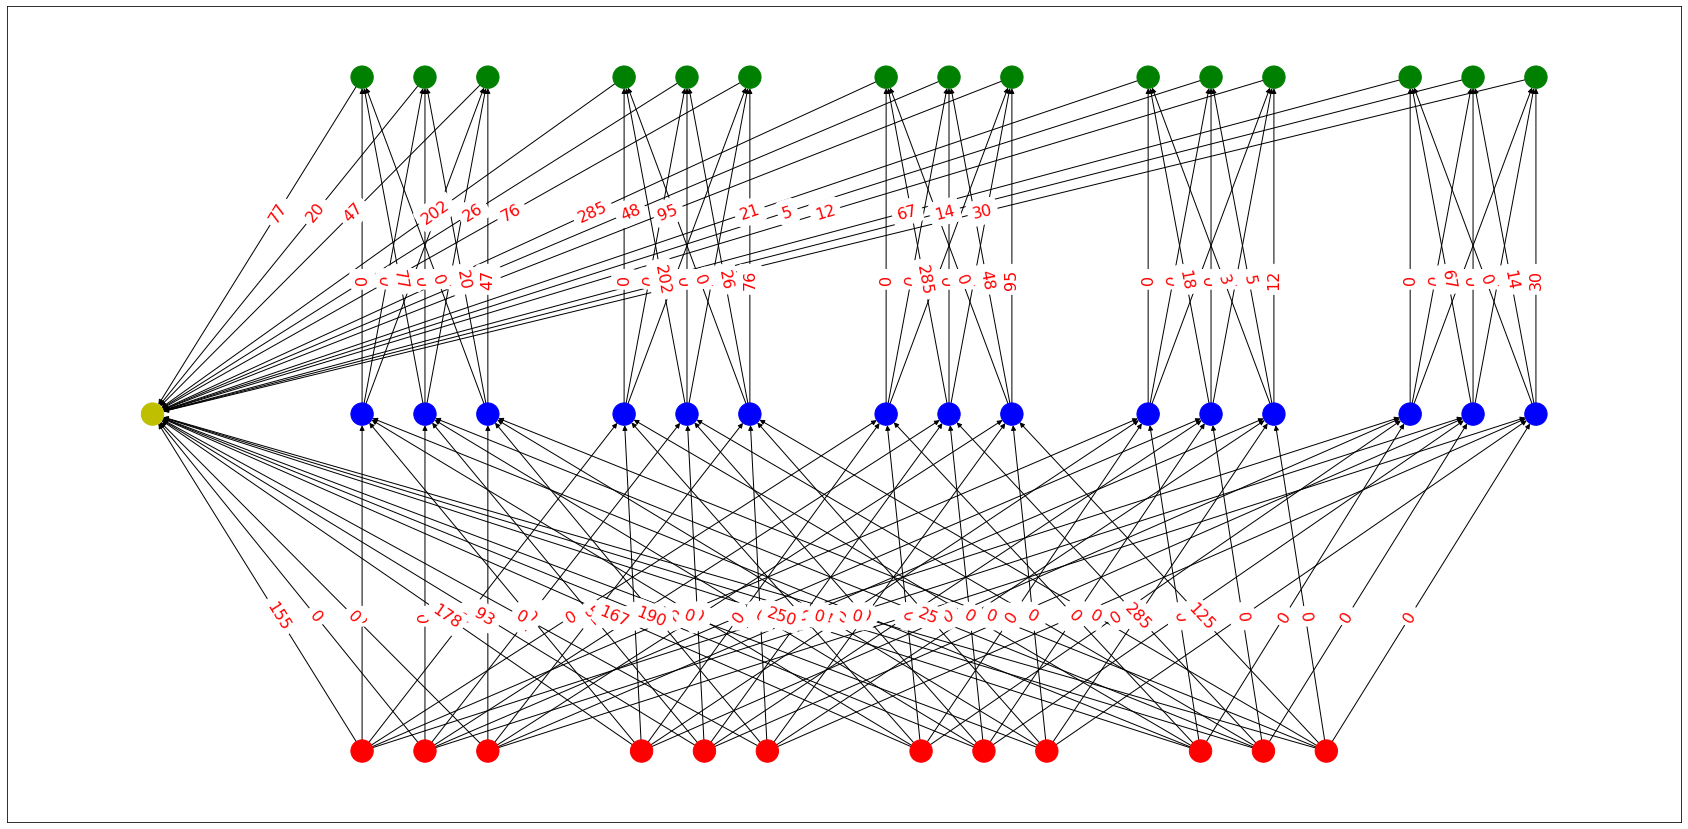

In [229]:
plt.figure(figsize=(30,15))
nx.draw_networkx(G, pos, node_color = color, node_size = 500, with_labels=False)
txt = nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_label, alpha = 1,\
                                  label_pos = 0.6, font_size = 16, font_color = 'r')

In [230]:
flow_to_df(output, home_file, hospital_file, age_file)

,The Pavilion,Provena Covenant Medical Ctr,Carle Foundation Hospital,John and Mary Kirby Hospital,Gibson Area Hosp & Hlth Servs,self-quarantine
ONE Illinois South Student Apartments,3,250,18,0,0,155
Capstone Quarters,52,54,0,0,111,271
The Place at 117,64,0,0,38,0,357
Illini Tower,25,0,410,0,0,250


In [231]:
output

{'The Pavilion Non-ICU Beds out': {'terminal': 77},
 'The Pavilion ICU Beds out': {'terminal': 20},
 'The Pavilion Ventillator out': {'terminal': 47},
 'The Pavilion 0-29 years in': {'The Pavilion Non-ICU Beds out': 0,
  'The Pavilion ICU Beds out': 0,
  'The Pavilion Ventillator out': 0},
 'The Pavilion 30-64 years in': {'The Pavilion Non-ICU Beds out': 77,
  'The Pavilion ICU Beds out': 0,
  'The Pavilion Ventillator out': 0},
 'The Pavilion 65+ years in': {'The Pavilion Non-ICU Beds out': 0,
  'The Pavilion ICU Beds out': 20,
  'The Pavilion Ventillator out': 47},
 'Provena Covenant Medical Ctr Non-ICU Beds out': {'terminal': 202},
 'Provena Covenant Medical Ctr ICU Beds out': {'terminal': 26},
 'Provena Covenant Medical Ctr Ventillator out': {'terminal': 76},
 'Provena Covenant Medical Ctr 0-29 years in': {'Provena Covenant Medical Ctr Non-ICU Beds out': 0,
  'Provena Covenant Medical Ctr ICU Beds out': 0,
  'Provena Covenant Medical Ctr Ventillator out': 0},
 'Provena Covenant Med